# Full MARS demo

This is the tutorial from the readme of MARS_Developer in Jupyter notebook form.

## 1. 📁 Create a new MARS Training Project

Your MARS project directory will contain all the files created during the process of training MARS detector and pose models on your data.

In addition to creating a project directory, `create_new_project` takes two optional arguments:
* Set `download_MARS_checkpoints=True` to download pre-trained MARS detection and pose models. If your dataset looks similar to MARS, initializing training from the pre-trained models should help decrease your training data requirements.
* Set `download_demo_data=True` to download a sample dataset, consisting of 2000 frames from videos in the [CRIM13 dataset](https://data.caltech.edu/records/1892), with accompanying manual annotations of animal pose collected via Amazon SageMaker. The sample dataset can also be previewed [here](https://drive.google.com/drive/u/0/folders/1J73k-RC1CyJQOjUdWr-75P3w_mfpRvXr).

In [1]:
from create_new_project import *

location = 'D:'
name = 'my_project'

create_new_project(location, name,
                   download_MARS_checkpoints=True,
                   download_demo_data=True)

I couldn't find the location D:


Within your project folder is a file called `project_config.yaml`. This file contains many important features: keypoint and animal names, instructions for your annotation job, and names/data assignments for detection and pose models. Open this file in a text editor and fill in the fields as instructed in the comments.

## 2. ✍️ Collect a set of manually annotated animal poses
In this step, we will get some training data for our detector and pose estimator.

> If you set `download_demo_data=True` in step 1, **skip to step 2.3** to format your data for training.

> If you've already annotated some poses in DeepLabCut, copy the annotation csv to `my_project/annotation_data`, and the images you annotated to `my_project/annotation_data/raw_images`. Set `manifest_name` in `project_config.yaml` to the name of your csv.
>
> Then **skip to step 2.3** to format your data for training.

### 2.1 Extract video frames that you would like to annotate
First, we need to collect a set of video frames to annotate for animal pose. Copy these videos into `my_project/annotation_data/behavior_movies`.

Now, we'll use `extract_frames_to_label` to sample frames from these movies. It takes as input a project path, plus two optional arguments:
* `n_frames` the number of frames to sample for labeling (default is 1000)
* `to_skip` omits the first X frames from each video during sampling (default is 0)

If you already have frames on hand but haven't annotated them, copy those images to `my_project/annotation_data/raw_images` so they can be accessed during the labelling job and later during model training.



In [2]:
from pose_annotation_tools.extract_frames_to_label import *

project_path = 'D:\my_project'
extract_frames_to_label(project_path, n_frames=5)

Couldn't find a project at D:\my_project


You should now have a folder `my_project/annotation_data/raw_images` of video frames.

### 2.2 Run a labeling job
Refer to [these instructions](https://github.com/neuroethology/MARS_Developer/blob/master/pose_annotation_tools/docs/readme_groundTruthSetup.md) to run a labeling job on Amazon SageMaker.

This job will produce a file called `output.manifest` which you should add to `my_project/annotation_data`. If you change the name of this manifest file, be sure to update the `manifest_name` field of `my_project/project_config.yaml` appropriately.

### 2.3 Post-process the manual pose annotations
This script carries out several steps to create "ground truth" keypoint locations by taking the median across AWS workers, correct for left/right flips of body part labels, and package your data for model-training. The processed annotation data will be added as a new file to `annotation_data`.

In [3]:
from pose_annotation_tools.annotation_postprocessing import *

project_path = 'D:\my_project'
annotation_postprocessing(project_path)

Instructions for updating:
non-resource variables are not supported in the long term


KeyboardInterrupt: 

### 2.4 Visualize some manual pose annotations

We'll next take a look at the inter-annotator variability in your pose labels, as this is a good predictor for how well MARS will perform. (If you annotated pose yourself you can skip this step.)

To look at annotations on an example frame, call `plot_frame`. It takes as input a project path and a number (specifying the image in your annotation dataset.) It also takes two optional plotting arguments:
* `markersize` the size of the keypoint makers (default is 8)
* `figsize` the width and height of the plot (default is [15,20])

The colored points are the raw annotation data. Points are colored by body part, and all points of a given marker shape come from the same worker. The black and white points are the medians across annotators. These medians are the "ground truth" that we'll use to train MARS.

In [ ]:
from pose_annotation_tools.evaluation import *

project_path = 'D:\my_project'
frame_num = 42  # the frame number to look at in your data

plot_frame(project_path,frame_num, markersize=5, figsize=[10,10])

To summarize worker performance, we'll look at the **Percent Correct Keypoints (PCK)**. This is the percentage of keypoints from individual workers that fall within a radius X of the "ground truth" worker median.

For each keypoint, we compute the distance from each worker's annotation to the median of the remaining workers, on each frame. We then plot cdfs of **median** (dashed line) worker-to-median distances for each frame, as well as a shaded area whose upper and lower bounds are the min and max worker-to-median distances, respectively.

The "all" plot takes the framewise average across keypoints, for each metric.

`plot_human_PCK` summarizes worker performance for your dataset. It takes four optional arguments:
* `animal_names` specifies which animals to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools data across animal types in your dataset.

In [ ]:
from pose_annotation_tools.evaluation import *

project_path = 'D:\my_project'
plot_human_PCK(project_path, combine_animals=False)

## 3. 🎯 Fine-tune the MARS detector to your data


### 3.1 Run the training code
`run_training` takes two optional arguments:
* `models` takes names of detectors to train, in case you only want to work on one detector at a time (MARS trains all detectors sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml` (300,000 by default). You can set this to a small number to confirm everything is working before launching your full training job.

If training is interrupted, it will resume from the most recent model checkpoint; MARS saves checkpoints every 30 minutes (adjust this in `my_project/detection/train_config.yaml`), and when training completes.

In [ ]:
from multibox_detection import train_detect

project_path = 'D:\my_project'
train_detect.run_training(project_path, max_training_steps=1500)

### 3.2 Visualize model performance and pick the best checkpoint
During training, we saved a model checkpoint every 30 minutes (by default). By testing model performance on a small held-out validation set, we can determine which checkpoint performs best, avoiding overfitting to the training set.

To see how far training has progressed, and whether performance might improve with more time, you can plot the validation loss (roughly, the error on the held-out validation set) with `plot_training_progress`. It takes four optional arguments:
* `detector_names` names of pose models to evaluate, as above.
* `figsize` width and height of the plot.
* `omitFirst` omits the first N training steps from plotting.
* `logTime` applies a log-scale to the x axis.

If the validation loss does not seem to have plateaued, your model performance may still improve with more training! Setting `logTime=True` and increasing the value of `omitFirst` can make it easier to see whether performance has plateaued.

In addition, we'll call `save_best_checkpoint` to identify the checkpoint with the greatest validation set performance, and extract it to a separate directory to be used for testing. It takes the optional argument:
* `detector_names` names of detection models to evaluate.

Even if performance hasn't plateaued, you can still proceed to **step 3.3** to evaluate the model on your test set. If you run additional training, be sure to call `save_best_checkpoint` again afterwards so your new best-performing checkpoint is used during testing.

In [ ]:
from multibox_detection import evaluate_detect

project_path = 'D:\my_project'
evaluate_detect.plot_training_progress(project_path, omitFirst=1000, logTime=False)
evaluate_detect.save_best_checkpoint(project_path)

### 3.3 Evaluate model performance on a held-out test set

After picking the checkpoint that performs best on your validation set, we can evaluate that model's performance on the test set:


First, we'll run our selected model on the test set. `run_test` takes optional arguments:
* `detector_names`, the subset of models to evaluate (defaults to all.)
* `num_images`, the number of images in the test set to evaluate on (defaults to all.)

It also returns an object `performance` that we can use to generate some figures.

In [ ]:
from multibox_detection import evaluate_detection

project_path = 'D:\my_project'
performance = evaluate_detection.run_test(project_path)

First, let's look at ground truth and predicted bounding boxes for a sample frame. The `Multibox Detection` model makes multiple object detection predictions, each with an associated confidence value.

MARS keeps only the box with the highest confidence score, however when plotting we also show all predicted bounding boxes with a confidence of 0.75 or higher. To change this threshold, modify the optional `confidence_thr` argument to be some value between 0 (lowest) and 1 (highest).

In [ ]:
from multibox_detection import evaluate_detection

project_path = 'D:\my_project'
frame_num = 11

evaluate_detection.plot_frame(project_path, frame_num, markersize=7, figsize=[10,10], confidence_thr=0.75)

Now let's get some summary statistics using the COCO API. The most common metric for evaluating detector performance is the **Intesection over Union (IoU)** - the ratio of the area of overlap between ground truth and predicted boxes, divided by the union of their areas- ie $(\textrm{ground truth} \cap \textrm{predicted})/(\textrm{ground truth} \cup \textrm{predicted})$.

We'll report the **mean Average Precision** and **mean Average Recall** (mAP and mAR) of the IoU, which are the average of Precision and Recall values computed over a range of thresholds on IoU values. This is a standard method for evaluating object detector performance; see the MARS manuscript for an explanation of this metric, or [this article](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3) for further reading.

In [ ]:
performance = evaluate_detection.coco_eval(project_path)

for model in performance.keys():
    print('Performance for ' + model + ':')
    performance[model].summarize()

Finally, we'll plot **PR Curves**, showing the Precision vs Recall of our detector for various confidence thresholds. Line color here indicates the minimum IoU required to be counted as a correct detection.

In [ ]:
from multibox_detection import evaluate_detection

project_path = 'D:\my_project'
evaluate_detection.pr_curve(project_path)

### 3.4 (Optional) test your detector on new videos

💡 If you are working with top-view mouse videos, it is possible that MARS's pose estimator will work for you out of the box now that you have a working detector. Skip to step 5 to try it out! If you're not happy with the performance, continue to step 4 where you'll be able to fine-tune the pose estimator.

## 4. 🐁 Fine-tune the MARS pose estimator to your data


### 4.1 Run the training code
Training the pose estimator is the same as training your detectors.

`run_training` again takes two optional arguments:
* `pose_model_names` takes names of pose models to train, in case you only want to work on one model at a time (MARS trains all models sequentially by default.)
* `max_training_steps` overrides `NUM_TRAIN_ITERATIONS` in `train_config.yaml`. You can set this to a small number to confirm everything is working before launching your full training job.

In [ ]:
from hourglass_pose import train_pose

project_path = 'D:\my_project'
train_pose.run_training(project_path)

### 4.2 Visualize model performance and extract the best checkpoint

As for the detector, we can check whether performance has plateaued and pick our best-performing version of the pose model.
You can plot the validation loss with `plot_training_progress`, which takes four optional arguments:
* `pose_model_names` names of pose models to evaluate, as above.
* `figsize` width and height of the plot.
* `omitFirst` omits the first N training steps from plotting.
* `logTime` applies a log-scale to the x axis.

And again, `save_best_checkpoint` will identify the pose model checkpoint with the greatest validation set performance, and extract it to a separate directory to be used for testing. It takes the optional argument:
* `pose_model_names` names of pose models to evaluate.

If the validation loss does not seem to have plateaued, your model performance may still improve with more training.

Even if performance hasn't plateaued, you can still proceed to **step 4.3** to evaluate your model on the test set. If you run additional training, be sure to call `save_best_checkpoint` again afterwards so your new best-performing checkpoint is used during testing.

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
evaluate_pose.plot_training_progress(project_path, omitFirst=1000, logTime=False)
evaluate_pose.save_best_checkpoint(project_path)

### 4.3 Evaluate model performance on a held-out test set

First, we'll run our selected model on the test set. `run_test` takes optional arguments:
* `pose_model_names`, the subset of models to evaluate (defaults to all.)
* `num_images`, the number of images in the test set to evaluate on (defaults to all.)

It also returns an object `performance` that we can use to generate some figures.

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
performance = evaluate_pose.run_test(project_path)

First, let's look at ground truth and predicted poses for a sample frame:

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
frame_num = 24

evaluate_pose.plot_frame(project_path, frame_num, markersize=7, figsize=[10,10])

Now let's get some summary statistics using the COCO API. First, the mean Average Precision and mean Average Recall (mAP and mAR) of the Object Keypoint Similarity (OKS) -- see our [notebook on pose evaluation](hourglass_pose/pose_evaluation_on_test_tfrecords.ipynb) for a tutorial on what these metrics mean.

In [ ]:
performance = evaluate_pose.coco_eval(project_path)
performance['top']['all'].summarize()

By default, these values are computed using the "narrow" setting of the OKS, $\sigma = 0.025$. If you use the same keypoint names as MARS, you can also compute performance using keypoint-specific $\sigma$ values from the MARS pose datasets:

In [ ]:
performance = evaluate_pose.coco_eval(project_path, view='top')
performance['top']['all'].summarize()

Finally, let's compare our PCK distribution from our model to what we got from our human annotators. `plot_model_PCK` takes similar arguments `plot_human_PCK`:
* `pose_model_names` specifies which models to generates plots for (defaults to all.)
* `xlim` is a two-element list specifying the min and max bounds of the x axis for all subplots.
* `pixel_units=True` plots in units of pixels instead of cm.
* `combine_animals=True` pools human annotation data across animal types in your dataset. Model performance plots are always pooled (to be fixed later.)

In [ ]:
from hourglass_pose import evaluate_pose

project_path = 'D:\my_project'
evaluate_pose.plot_model_PCK(project_path, combine_animals=True)

## 5. 🚀 Deploy your new detection and pose models

To use your trained models with the end-user version of MARS, we will export them as protobuf (`.pb`) files, which are saved to your main project folder.

`export` takes the optional arguments:
* `detector_names` specifies which detection models to save (defaults to all.)
* `pose_model_names` specifies which pose models to save (defaults to all.)


Copy the created files to your end-user version of MARS, in `mars_v1_8\models\detection` and `mars_v1_8\models\pose`. To run MARS using the new models, either modify the default settings in `mars_v1_8\config.yml`, or specify the model paths during runtime.

In [ ]:
import export_models

project_path = 'D:\my_project'
export_models.export(project_path)

## 6. 💪 Train new behavior classifiers

In the final section of this tutorial, we will train classifiers to detect behaviors of interest in your tracked videos. MARS is a *supervised* classification system, meaning that it requires labeled training examples of the behaviors you would like to detect.

You can use our Matlab-based interface [Bento](https://github.com/neuroethology/bentoMAT) to create frame-by-frame manual annotations of behavioral videos- for more information see [this page](https://github.com/neuroethology/bentoMAT/wiki/Annotating-Your-Data) of the Bento wiki. (A Python version of Bento will be available soon.)

### 6.1 Assemble your videos and annotations

To train MARS behavior classifiers, you will need to add the following files to `project_path\behavior\behavior_data`:
- The raw videos you have annotated for your behavior of interest
- MARS pose estimates produced from those videos (filename ends in `_raw_pose_v###.json` (where ### is the version number of MARS))
- Your manual annotations of animals' behaviors
    - MARS currently supports annotations produced by [the Caltech Behavior Annotator](https://github.com/pdollar/toolbox/blob/master/videos/behaviorAnnotator.m) or by [Bento](https://github.com/neuroethology/bentoMAT). Support for other annotation formats will be happily added- please [contact us](mailto:ann.kennedy@northwestern.edu) with requests.

MARS uses a filename-based system for matching up videos to their corresponding pose estimates and annotations: so long as video, annotation, and pose estimates all begin with the same string, MARS will do its best to match them.

To check that all your files are found and paired up correctly, call `check_annotation_data`:

In [9]:
from behavior_classification import behavior_setup

project_path = 'D:\my_project'

behavior_setup.check_behavior_data(project_path)

Processing behavior annotations in project D:\my_project
  89 total videos found.
  all videos successfully matched with annotation and pose files!
List of behavior annotations found:
  mount
  attack
  investigation


If everything seems to be in order, use `prep_behavior_data` to split your dataset into training, validation, and test sets. This takes the following optional arguments:
- `val` sets the fraction of data assigned to the validation set (defaults to 0.1, ie 10\%)
- `test` sets the fraction of data assigned to the test set (defaults to 0.2, ie 20\%)
- `reshuffle` re-assigns videos to train, validation, and test sets (defaults to `True`.)

Three important notes here:

- Each video in your dataset will be assigned to one set (train, validation, or test). The sizes of validation/test sets are therefore approximate- videos will be added to validation and test until at least `val`\% of frames are in the validation set and `test`\% in the test set; the remainder of videos will be assigned to the training set.
- The validation set is used to prevent overfitting to your training data, therefore you shouldn't set its size to zero.
- If the behavior you are studying is rare, you may want to manually assign files to the validation and test sets, to make sure it is adequately represented. You can do this by editing the contents of `project_path\behavior\train_test_split.yaml`. To re-generate the behavior pie graphs shown below without re-shuffling the data, call `prep_behavior_data` with optional flag `reshuffle=False`.

Delete existing train/test splits and reshuffle? (y/n)n


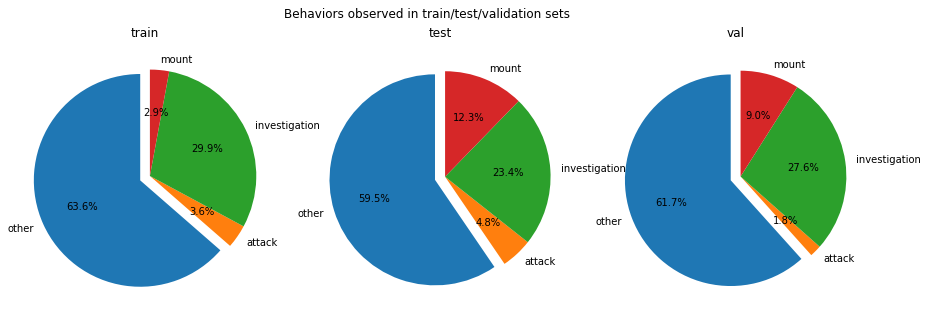

In [1]:
from behavior_classification import behavior_setup

project_path = 'D:\my_project'

behavior_setup.prep_behavior_data(project_path, reshuffle=False)

Finally, once you're happy with your splits, call `apply_clf_splits` to package data for classifier training. This script packages pose and annotation data into `.json` files, using the formatting convention established for [the CalMS21 dataset](https://data.caltech.edu/records/1991):

```json
{
    "vocabulary": {
        "other": 0,
        "(behavior_1)": 1,
        "(behavior_2)": 2
    }
    "sequences": {
        "my_project": {
            "name_of_video_1": {
                "keypoints": [],
                "bbox": [],
                "scores": [],
                "annotations": [],
                "metadata": {}
            },
            "name_of_video_2": {
                "keypoints": [],
                "bbox": [],
                "scores": [],
                "annotations": [],
                "metadata": {}        
            },
        }
    }
}
```
The `metadata` field will contain your original file paths, for safekeeping. Annotations are converted to a vector of integers, whose mapping to behavior labels is defined by the `vocabulary` dictionary.

In [2]:
from behavior_classification import behavior_setup

project_path = 'D:\my_project'

behavior_setup.apply_clf_splits(project_path)

saving train set...
saving test set...
saving val set...


### 6.2 Extract features from pose/video files

MARS extracts a set of custom-designed features from animals' poses, and uses these features to detect behaviors of interest.

Feature extraction is currently only supported for poses using the original MARS keypoint definitions (nose, ears, neck, hips, and tail, from two mice.) An update supporting more general feature extraction is in progress.

In [ ]:
from behavior_classification import MARS_feature_extractor

project_path = 'D:\my_project'

MARS_feature_extractor.extract_features(project_path)

### 6.3 Define annotation equivalences
If your training data is compiled from many old experiments, you may discover that annotators have used different names to refer to the same behavior. Or, you may want to combine multiple more fine-grained labels to create a broader behavior classifier.

MARS allows you to combine behaviors by creating `equivalences`, implemented as a python dictionary. For example, the following `equivalences` dictionary would look for any of the labels listed on the right, and use these as positive examples when training a classifier to detect the behavior `sniff_face`:

```
equivalences = {'sniff_face': ['sniffface', 'sniff-face', 'sniff_face', 'head-investigation','facesniffing']}
```

You can define `equivalences` for your project using the `set_equivalences` function. If you don't call this function, MARS will only look for annotations that match your target behavior exactly.

In [ ]:
from behavior_classification import behavior_setup

equivalences = {'sniff_face':     ['sniffface', 'snifface', 'sniff-face', 'sniff_face',
                                   'head-investigation','facesniffing'],
            'sniff_genital':      ['sniffurogenital','sniffgenitals','sniff_genitals',
                                   'sniff-genital','sniff_genital','anogen-investigation'],
            'sniff_body':         ['sniff_body','sniffbody','bodysniffing','body-investigation',
                                   'socialgrooming','sniff-body','closeinvestigate',
                                   'closeinvestigation','investigation'],
            'investigation':      ['sniffface', 'snifface', 'sniff-face', 'sniff_face',
                                   'head-investigation','facesniffing','sniffurogenital',
                                   'sniffgenitals','sniff_genitals','sniff-genital',
                                   'sniff_genital','anogen-investigation','sniff_body',
                                   'sniffbody', 'bodysniffing', 'body-investigation',
                                   'socialgrooming','sniff-body', 'closeinvestigate',
                                   'closeinvestigation', 'investigation','investigate',
                                   'first_inv','aggressive_investigation','attack_attempt',
                                   'mount_attempt','dom_mount_attempt'],
            'mount':              ['mount','aggressivemount','intromission','dom_mount','ejaculate'],
            'attack':             ['attack','attempted_attack','chase']}


project_path = 'D:\my_project'

behavior_setup.set_equivalences(project_path, equivalences)

### 6.4 Train your behavior classifier!

Finally, you can use the following command to train a new MARS classifier for a specified behavior of interest. MARS will check the `equivalences` you defined above; if it finds the specified behavior among the dictionary keys, it will include all corresponding entries associated with that key when defining positive examples of that behavior.

`train_classifier` takes a list of behaviors you want to train classifiers for, plus one optional argument:
- `drop_behaviors` will omit all frames with the listed annotation(s) from the training set. You can use this to exclude portions of a video (eg where behavior hasn't been annotated or the experimenter's hand is in the cage) from training.

In [ ]:
from behavior_classification import MARS_train_test

project_path = 'D:\my_project'

results = MARS_train_test.train_classifier(project_path, ['attack','investigation','mount'])

### 6.5 Evaluate classifier performance on a held-out test set

Finally, you can test the performance of your trained classifier on a test set of videos. Performance is reported in terms of the classifier **Precision** and **Recall**, defined as:
$$\textrm{Precision} = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Positives}}$$
$$ $$
$$\textrm{Recall} = \frac{\textrm{True Positives}}{\textrm{True Positives} + \textrm{False Negatives}}$$

In [ ]:
from behavior_classification import MARS_train_test

project_path = 'D:\my_project'

MARS_train_test.test_classifier(project_path, ['attack','investigation','mount'])

If you're not happy with classifier performance, you can use Bento to manually correct errors in MARS predictions on other (non-test) videos to increase the size of your training set. You may also want to experiment with adjusting classifier parameters- this can be done by editing classifier settings in `project/behavior/config_classifiers.yaml`.

### 6.6 Deploy your trained behavior model

This is the last step!